In [1]:
# 标准库
import os

# 科学计算与数据处理
import numpy as np
import pandas as pd

# 地理空间数据处理
import geopandas as gpd

# 可视化
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import statsmodels.api as sm

# matplotlib 辅助模块
from matplotlib import ticker
from matplotlib.colors import BoundaryNorm, ListedColormap, LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.patches import Wedge
from matplotlib.collections import PatchCollection
import matplotlib.font_manager as fm
import matplotlib.gridspec as gridspec

# 其他可选模块（根据需要启用）
# import jenkspy                  # 自然断点分类法
# import openpyxl                # Excel 读写支持
# import palettable              # 颜色板工具

#检查当前工作目录
print(os.getcwd())

#修改当前工作目录
os.chdir("/public/home/jiaqizhang/JiaqiZhang/project-CCFR/02.Analysis and figures/01.notebook/Figure7.CCFR_upper envolope function")

#检查当前工作目录
print(os.getcwd())

/public/home/jiaqizhang
/public/home/jiaqizhang/JiaqiZhang/project-CCFR/02.Analysis and figures/01.notebook/Figure7.CCFR_upper envolope function


In [2]:
#------------------------------------------打开次国家边界的shp文件----------------------------------------

# 读取边界文件
subcountry = gpd.read_file("/public/home/jiaqizhang/JiaqiZhang/data-doctor3/country/ne_10m_admin_1_states_provinces.shp", engine="pyogrio")

# 过滤掉 code_hasc 以 ~ 结尾的行
subcountry = subcountry[~subcountry['code_hasc'].str.endswith('~', na=False)]

# 筛选台湾地区（以 "TW.TW." 开头的 code_hasc）
taiwan = subcountry[subcountry['code_hasc'].str.startswith('TW.')]
# 合并台湾的各行政区为一个整体边界
taiwan_merged = taiwan.dissolve(by=lambda x: 'TW')
# 添加一个字段表示国家代码
taiwan_merged['country'] = 'CN'
taiwan_merged['name'] = 'Taiwan'
taiwan_merged['code_hasc'] = 'CN.TW'
print(taiwan_merged['code_hasc'])  # 或 'hasc_code'，看原始字段名
# 如果你想将这个合并结果加入原始数据（并删除原本的台湾省份）
boundary_no_tw = subcountry[~subcountry['code_hasc'].str.startswith('TW.')]
subcountry = pd.concat([boundary_no_tw, taiwan_merged], ignore_index=True)


# 筛选香港地区（以 "HK." 开头的 code_hasc）
hongkong = subcountry[subcountry['code_hasc'].str.startswith('HK.')]
# 合并香港的各行政区为一个整体边界
hongkong_merged = hongkong.dissolve(by=lambda x: 'HK')
# 添加一个字段表示国家代码
hongkong_merged['country'] = 'CN'
hongkong_merged['name'] = 'Hongkong'
hongkong_merged['code_hasc'] = 'CN.HK'
print(hongkong_merged['code_hasc'])  # 或 'hasc_code'，看原始字段名
# 如果你想将这个合并结果加入原始数据（并删除原本的台湾省份）
boundary_no_hk = subcountry[~subcountry['code_hasc'].str.startswith('HK.')]
subcountry = pd.concat([boundary_no_hk, hongkong_merged], ignore_index=True)

print(len(subcountry))

#------------------------------------------打开国家边界的shp文件----------------------------------------
continent = gpd.read_file("/public/home/jiaqizhang/JiaqiZhang/data-doctor3/country/ne_10m_admin_0_countries_chn.shp", engine="pyogrio")

# # 打印前5行数据查看
# print(continent_gdf.head())

# # Print all column names
# print(continent_gdf.columns.tolist())

# print(len(continent_gdf))

TW    CN.TW
Name: code_hasc, dtype: object
HK    CN.HK
Name: code_hasc, dtype: object
4457


In [9]:
##------------------------------------------打开gridnet洪水数据的shp文件----------------------------------------

shp_file_path = "/public/home/jiaqizhang/JiaqiZhang/project-CCFR/01.Processed data/11.GDP/gridnet_GDP_CCFR.shp"

gridnet= gpd.read_file(shp_file_path, engine="pyogrio")
#计算CCFR
gridnet['CCFRtake'] = (gridnet['CCFH_qtl']* gridnet['GDP_qtl']) ** (1/2) 
gridnet['CCFRaverse'] = (gridnet['CCFH_qtl']* gridnet['pop_qtl'] * gridnet['G_capinv_q'] ) ** (1/3)  # 开三次方
print("风险值计算完成")

# 替换多列的空值为 0
columns_to_fill = ['CF_Hazard', 'RF_Hazard']
gridnet[columns_to_fill] = gridnet[columns_to_fill].fillna(0)

# 计算比值，如果分母为 0，则设置为最大值 100
gridnet['ORratio'] = np.where(
    gridnet['RF_Hazard'] != 0,  # 分母不为 0
    gridnet['CF_Hazard'] / gridnet['RF_Hazard'],  # 正常计算比值
    100  # 如果分母为 0，设置为最大值 100
)

# 将 ORratio 中的值限制在 [0, 100] 范围内
gridnet['ORratio'] = np.clip(gridnet['ORratio'], 0, 100)

gridnet['TF_Hazard'] = gridnet['TF_Hazard'].replace(0, np.nan)  # 将 0 替换为 NaN
# 查看矢量的前5行/投影/列名/行数
# print(gridnet.head())
print(gridnet.crs)
print(gridnet.columns)  
print(len(gridnet))


风险值计算完成
EPSG:4326
Index(['A_CFrp0005', 'A_CFrp0010', 'A_CFrp0025', 'A_CFrp0050', 'A_CFrp0100',
       'A_CFrp0250', 'A_CFrp0500', 'A_CFrp1000', 'A_RFrp0005', 'A_RFrp0010',
       'A_RFrp0025', 'A_RFrp0050', 'A_RFrp0100', 'A_RFrp0250', 'A_RFrp0500',
       'A_RFrp1000', 'D_CFrp0005', 'D_CFrp0010', 'D_CFrp0025', 'D_CFrp0050',
       'D_CFrp0100', 'D_CFrp0250', 'D_CFrp0500', 'D_CFrp1000', 'D_RFrp0005',
       'D_RFrp0010', 'D_RFrp0025', 'D_RFrp0050', 'D_RFrp0100', 'D_RFrp0250',
       'D_RFrp0500', 'D_RFrp1000', 'FDD_km-1', 'FH_rp0005', 'FH_rp0010',
       'FH_rp0025', 'FH_rp0050', 'FH_rp0100', 'FH_rp0250', 'FH_rp0500',
       'FH_rp1000', 'MangA_km2', 'T2m', 'T_rivLC_km', 'Tp', 'V_CFrp0005',
       'V_CFrp0010', 'V_CFrp0025', 'V_CFrp0050', 'V_CFrp0100', 'V_CFrp0250',
       'V_CFrp0500', 'V_CFrp1000', 'V_RFrp0005', 'V_RFrp0010', 'V_RFrp0025',
       'V_RFrp0050', 'V_RFrp0100', 'V_RFrp0250', 'V_RFrp0500', 'V_RFrp1000',
       'area_km2', 'area_m2', 'dem', 'net_ID', 'saltA_km2', 'sla', 'wi

/public/home/jiaqizhang/anaconda/ENTER/envs/geo/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


-14.12


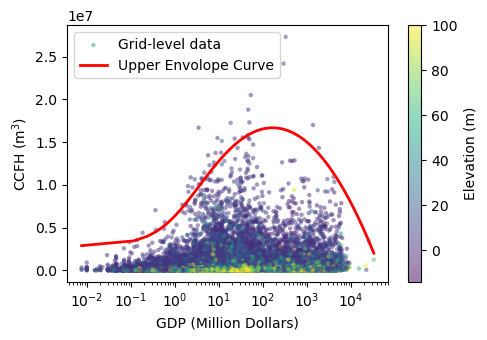

In [4]:


# 准备数据（假设 gridnet 是你的 DataFrame，且 GDP>0）
df = gridnet[gridnet["GDP"] > 0].copy()

# 取对数 GDP（或者用原 GDP，根据你拟合效果决定）
df["log_GDP"] = np.log10(df["GDP"]+1)

# 构造二次项
df["log_GDP_sq"] = df["log_GDP"] ** 2

# 自变量，加入常数项
X = df[["log_GDP", "log_GDP_sq"]]
X = sm.add_constant(X)

# 因变量
y = df["TF_Hazard"]

# 建立并拟合 95% 分位数回归模型
model = sm.QuantReg(y, X)
res = model.fit(q=0.999)

# 构造预测数据（细分 log_GDP）
log_gdp_grid = np.linspace(df["log_GDP"].min(), df["log_GDP"].max(), 100)
X_pred = pd.DataFrame({
    "const": 1,
    "log_GDP": log_gdp_grid,
    "log_GDP_sq": log_gdp_grid ** 2
})

# 预测 95% 分位数值
y_pred = res.predict(X_pred)

dem_min = df['dem'].min()  # 注意这里有括号
dem_max = df['dem'].max()
print(dem_min)
# 画图
plt.figure(figsize=(5, 3.5))
scatter = plt.scatter(df["GDP"], y, c=df["dem"],
                      alpha=0.5, edgecolor='none', cmap='viridis', s=10,vmin=dem_min, vmax=100, label='Grid-level data')
plt.plot(10**log_gdp_grid - 1, y_pred, 'r-', linewidth=2, label='Upper Envolope Curve')


plt.xscale("log")
plt.xlabel("GDP (Million Dollars)")
plt.ylabel("CCFH (m$^3$)")
# plt.title("Quadratic 99.9% Quantile Regression Upper Envelope")
cbar = plt.colorbar(scatter)
cbar.set_label("Elevation (m)")
plt.legend()
plt.tight_layout()
# ---- 保存 & 展示 ----
plt.savefig('CCFH_GDP_upperenvolope.pdf', format='pdf', bbox_inches='tight')
plt.show()


In [6]:
coef = res.params
print(f"拟合公式：")
print(f"TF_Hazard = {coef['const']:.4f} + {coef['log_GDP']:.4f} * log10(GDP+1) + {coef['log_GDP_sq']:.4f} * (log10(GDP+1))^2")
# 1. 计算 log_GDP 和平方项
df['log_GDP'] = np.log10(df['GDP'] + 1)

# 2. 提取拟合系数
coef = res.params

# 3. 计算拟合的上包络函数值
df['f_upper'] = (coef['const'] +
                 coef['log_GDP'] * df['log_GDP'] +
                 coef['log_GDP_sq'] * df['log_GDP']**2)

# 4. 处理 f_upper 小于等于0的异常，避免除零或负值
df.loc[df['f_upper'] <= 0, 'f_upper'] = np.nan

# 5. 计算 vulnerability
df['vulnerability'] = df['TF_Hazard'] / df['f_upper']

# 6. 将超过1的 vulnerability 强制设为1
df.loc[df['vulnerability'] > 1, 'vulnerability'] = 1

# 7. 查看结果
print(df.columns)
# 查看 vulnerability 列的描述性统计
print(df['vulnerability'].describe())


拟合公式：
TF_Hazard = 2859277.5598 + 12396902.9308 * log10(GDP+1) + -2780591.3663 * (log10(GDP+1))^2
Index(['A_CFrp0005', 'A_CFrp0010', 'A_CFrp0025', 'A_CFrp0050', 'A_CFrp0100',
       'A_CFrp0250', 'A_CFrp0500', 'A_CFrp1000', 'A_RFrp0005', 'A_RFrp0010',
       'A_RFrp0025', 'A_RFrp0050', 'A_RFrp0100', 'A_RFrp0250', 'A_RFrp0500',
       'A_RFrp1000', 'D_CFrp0005', 'D_CFrp0010', 'D_CFrp0025', 'D_CFrp0050',
       'D_CFrp0100', 'D_CFrp0250', 'D_CFrp0500', 'D_CFrp1000', 'D_RFrp0005',
       'D_RFrp0010', 'D_RFrp0025', 'D_RFrp0050', 'D_RFrp0100', 'D_RFrp0250',
       'D_RFrp0500', 'D_RFrp1000', 'FDD_km-1', 'FH_rp0005', 'FH_rp0010',
       'FH_rp0025', 'FH_rp0050', 'FH_rp0100', 'FH_rp0250', 'FH_rp0500',
       'FH_rp1000', 'MangA_km2', 'T2m', 'T_rivLC_km', 'Tp', 'V_CFrp0005',
       'V_CFrp0010', 'V_CFrp0025', 'V_CFrp0050', 'V_CFrp0100', 'V_CFrp0250',
       'V_CFrp0500', 'V_CFrp1000', 'V_RFrp0005', 'V_RFrp0010', 'V_RFrp0025',
       'V_RFrp0050', 'V_RFrp0100', 'V_RFrp0250', 'V_RFrp0500', 'V_RF

In [7]:
# 按倒数GDP列计算10分位数分组
df['Vul_qtl'] = pd.qcut(df['vulnerability'], 10, labels=np.linspace(0.1, 1, 10))
df['Vul_qtl'] = df['Vul_qtl'].astype(float)

print(df[['Vul_qtl']].head())

df['CCFR'] = (df['CCFH_qtl']* df['pop_qtl'] * df['Vul_qtl'] ) ** (1/3)  # 开三次方
# 7. 查看结果
print(df.columns)

   Vul_qtl
1      0.3
2      0.1
5      0.5
6      0.1
7      0.1
Index(['A_CFrp0005', 'A_CFrp0010', 'A_CFrp0025', 'A_CFrp0050', 'A_CFrp0100',
       'A_CFrp0250', 'A_CFrp0500', 'A_CFrp1000', 'A_RFrp0005', 'A_RFrp0010',
       'A_RFrp0025', 'A_RFrp0050', 'A_RFrp0100', 'A_RFrp0250', 'A_RFrp0500',
       'A_RFrp1000', 'D_CFrp0005', 'D_CFrp0010', 'D_CFrp0025', 'D_CFrp0050',
       'D_CFrp0100', 'D_CFrp0250', 'D_CFrp0500', 'D_CFrp1000', 'D_RFrp0005',
       'D_RFrp0010', 'D_RFrp0025', 'D_RFrp0050', 'D_RFrp0100', 'D_RFrp0250',
       'D_RFrp0500', 'D_RFrp1000', 'FDD_km-1', 'FH_rp0005', 'FH_rp0010',
       'FH_rp0025', 'FH_rp0050', 'FH_rp0100', 'FH_rp0250', 'FH_rp0500',
       'FH_rp1000', 'MangA_km2', 'T2m', 'T_rivLC_km', 'Tp', 'V_CFrp0005',
       'V_CFrp0010', 'V_CFrp0025', 'V_CFrp0050', 'V_CFrp0100', 'V_CFrp0250',
       'V_CFrp0500', 'V_CFrp1000', 'V_RFrp0005', 'V_RFrp0010', 'V_RFrp0025',
       'V_RFrp0050', 'V_RFrp0100', 'V_RFrp0250', 'V_RFrp0500', 'V_RFrp1000',
       'area_km2', 'ar

/tmp/ipykernel_36370/2246154938.py:20: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df['lon'] = df.geometry.centroid.x
/tmp/ipykernel_36370/2246154938.py:21: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df['lat'] = df.geometry.centroid.y


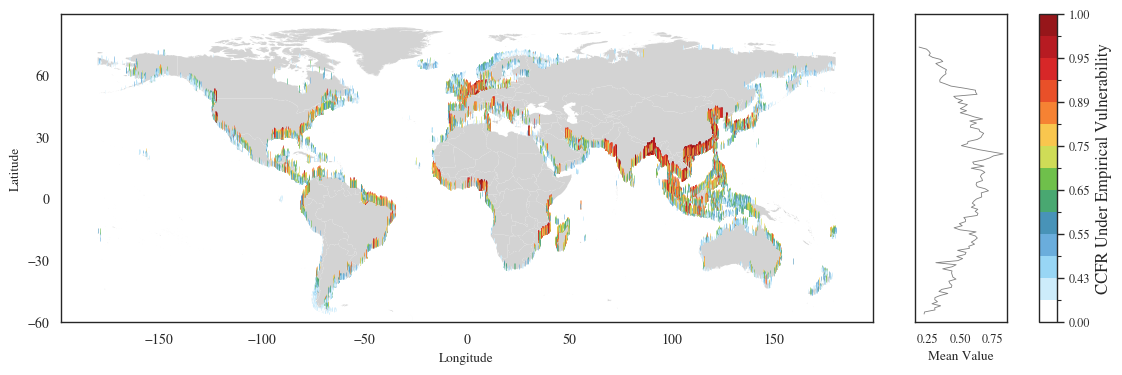

In [17]:
# ---- 创建自定义颜色映射 ----
def create_colormap():
    colors = np.genfromtxt('/public/home/jiaqizhang/JiaqiZhang/data-doctor3/WhiteBlueGreenYellowRed.rgb', skip_header=2) / 255
    return mpl.colors.ListedColormap(colors)

# ---- 基础参数 ----
sns.set(style='white', context='paper')
plt.rcParams['font.family'] = 'Nimbus Roman'

rp = 'CCFR'
breaks = [0, 0.27144176, 0.43267487,
          0.49324241, 0.55178484, 0.6, 0.65421326, 0.70472987, 0.74888724,
          0.81432528, 0.887904,0.92, 0.95, 0.98, 1]
# breaks = np.quantile(df["CCFR"].dropna(), np.linspace(0, 1, 10))  # 自动计算颜色分段
cmap = create_colormap()
norm = BoundaryNorm(breaks, cmap.N)

# ---- 数据预处理 ----
df[rp] = df[rp].replace(0, np.nan)
df['lon'] = df.geometry.centroid.x
df['lat'] = df.geometry.centroid.y

# ---- 创建 Figure + GridSpec ----
fig = plt.figure(figsize=(13, 4))  # 移除 constrained_layout
gs = gridspec.GridSpec(1, 3, width_ratios=[9, 1, 0.2], height_ratios=[1], wspace=0.1)
# ---- 子图 ----
ax_map = fig.add_subplot(gs[0])
ax_line = fig.add_subplot(gs[1])
ax_cbar = fig.add_subplot(gs[2])

# ---- 绘制地图 ----
continent.to_crs(epsg=4326).plot(ax=ax_map, color='lightgrey', edgecolor='none')

# gridnet.to_crs(epsg=4326).plot(
#     ax=ax_map,
#     column=rp,
#     cmap=cmap,
#     legend=False,
#     markersize=0.2,
#     edgecolor='none',
#     norm=norm
# )

# ---- 叠加柱子 ----
gridnet_bars = df[['lon', 'lat', rp]].dropna()
scale_factor = 5

for _, row in gridnet_bars.iterrows():
    lon = row['lon']
    lat = row['lat']
    height = row[rp] * scale_factor
    color = cmap(norm(row[rp]))
    ax_map.vlines(x=lon, ymin=lat, ymax=lat + height, color=color, linewidth=0.5, alpha=0.8)

# ---- 地图坐标轴设置 ----
ax_map.set_xlabel("Longitude")
ax_map.set_ylabel("Latitude")
latitude_range = np.arange(-60, 90, 30)
ax_map.set_ylim([-60, 90])
ax_map.set_yticks(latitude_range)
ax_map.tick_params(axis='both', labelsize=10)
# 不用 set_aspect('equal')，保持 map 和 colorbar 一致高

# ---- 绘制纬度均值折线图 ----
gridnet_1 = df[['lat', rp]].dropna()
gridnet_1['lat_group'] = (gridnet_1['lat'] // 1) * 1
latitude_grouped = gridnet_1.groupby('lat_group')[rp].mean()

ax_line.plot(latitude_grouped.values, latitude_grouped.index, color='tab:grey', linewidth=0.6)
ax_line.set_xlabel("Mean Value")
ax_line.set_ylim([-60, 90])
ax_line.set_yticks(latitude_range)
ax_line.set_yticks([])  # 隐藏y轴刻度
# ---- Colorbar ----
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, cax=ax_cbar)
cbar.set_label("CCFR Under Empirical Vulnerability", fontsize=12)
cbar.formatter = ticker.FuncFormatter(lambda x, pos: f"{x:.2f}")
cbar.update_ticks()

# ---- 保存 & 展示 ----
plt.savefig('CCFR_grid.pdf', format='pdf', bbox_inches='tight')
plt.show()


37675
Top 15 Provinces by CCFR:
code_hasc     CCFR  population          GDP
    VN.HP 1.000000    108640.0   212.049637
    VN.TB 1.000000    115589.0    66.979519
    VN.ND 1.000000    110381.0    76.835022
    VN.BI 1.000000    213910.0  1362.534058
    TH.RT 1.000000     47580.0   733.906372
    BD.BA 1.000000     75445.0    41.014633
    VN.HY 1.000000    115589.0    60.027880
    JP.GF 0.966085     53612.0  5861.347656
    MO.MA 0.966085    599100.5 15693.654785
    VN.DN 0.965489     80972.0  1362.534058
    KR.IN 0.965489     35448.0  2998.270996
    IN.WB 0.965489    106259.0    52.918304
    SR.PM 0.965489     42954.0   236.136414
    KP.PB 0.965489    174396.0   834.938477
    NL.NH 0.965489     27623.5  1955.872803


/tmp/ipykernel_36370/1502256672.py:36: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  province_centroids['geometry'] = province.centroid


4457
CCFR_level            Q1         Q2         Q3         Q4         Q5
CONTINENT                                                           
Africa         19.148936  17.553191  16.489362  26.595745  20.212766
Asia            5.655527  11.568123  23.650386  23.907455  35.218509
Europe         25.265957  23.936170  14.627660  19.148936  17.021277
North America  35.260116  24.855491  21.965318  15.606936   2.312139
Oceania        51.851852  29.629630  14.814815   3.703704   0.000000
South America  19.780220  27.472527  24.175824  18.681319   9.890110


/tmp/ipykernel_36370/1502256672.py:56: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  continent_summary = country_with_continent.groupby(['CONTINENT', 'CCFR_level']).size().unstack().fillna(0)
/tmp/ipykernel_36370/1502256672.py:69: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  continents_merged['center'] = continents_merged.geometry.centroid
/tmp/ipykernel_36370/1502256672.py:74: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  continent_with_pie 

[0, 0.33, 0.51057896, 0.62996052, 0.66943295, 0.76630943, 0.84343267, 0.9, 0.98, 1]


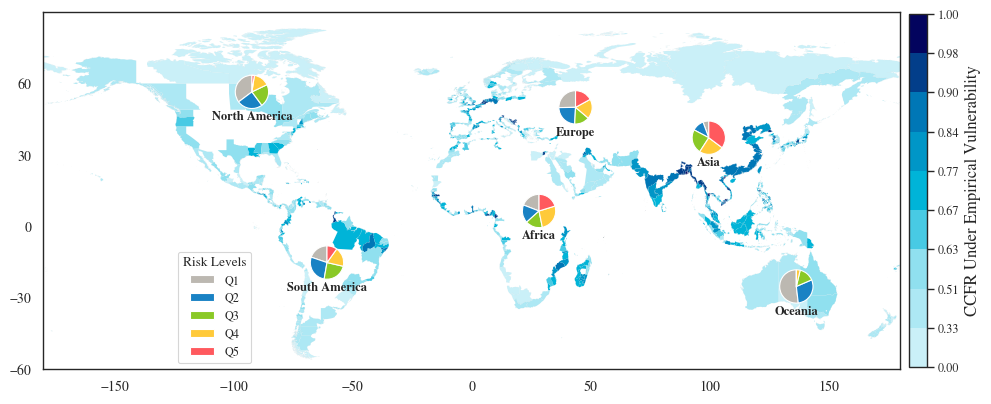

In [15]:
# ---------------------------- 设置样式 ----------------------------
# 设置全局样式，指定为白色网格，并调整字体大小
sns.set(style='white', context='paper')  # 'paper' 适合论文
plt.rcParams['font.family'] = 'Nimbus Roman'

# ---------------------------- 数据准备 ----------------------------
# 使用空间连接，将国家与网格连接
joined = gpd.sjoin(df, subcountry, how="left", predicate="intersects")

# 打印结果，检查中位数计算是否正确
print(len(joined))

# 统计多个指标的中位数
province_medians = joined.groupby('code_hasc')[['CCFR', 'population', "GDP"]].median().reset_index()

# 保留需要的列并合并结果
province = subcountry[['geometry', 'code_hasc']]
province = province.merge(province_medians, on='code_hasc', how='left')
province.to_excel('CCFR_province.xlsx', index=False)

# 打印 CCFRtake 最高的前 15 个区域
top15 = province[['code_hasc', 'CCFR', 'population', 'GDP']].sort_values(
    by='CCFR', ascending=False
).head(15)

print("Top 15 Provinces by CCFR:")
print(top15.to_string(index=False))


# 将国家划归到洲
# 1. 去除 'Seven seas (open ocean)' 分类
continent_gdf = continent[continent['CONTINENT'] != 'Seven seas (open ocean)']

# 计算 province 每个多边形的中心点
province_centroids = province.copy()
province_centroids['geometry'] = province.centroid


country_with_continent = gpd.sjoin(province_centroids, continent_gdf[['geometry', 'CONTINENT']], 
                                 how="left", predicate="intersects")

print(len(country_with_continent))

# ---------------------------- 计算CCFR等级 ----------------------------
# 使用5个等级
ccfr_quantiles = np.quantile(country_with_continent['CCFR'].dropna(), 
                            [0, 0.2, 0.4, 0.6, 0.8, 1])
country_with_continent['CCFR_level'] = pd.cut(
    country_with_continent['CCFR'],
    bins=ccfr_quantiles,
    labels=['Q1', 'Q2', 'Q3', 'Q4', 'Q5'],
    include_lowest=True
)

# 按洲统计每个等级的数量
continent_summary = country_with_continent.groupby(['CONTINENT', 'CCFR_level']).size().unstack().fillna(0)
continent_summary_percentage = continent_summary.div(continent_summary.sum(axis=1), axis=0) * 100
continent_summary_percentage = continent_summary_percentage.fillna(0)
print(continent_summary_percentage)
# ---------------------------- 准备饼图数据 ----------------------------
# 合并各洲的几何图形
continents_merged = continent_gdf.dissolve(by='CONTINENT').reset_index()

# 确保使用合适的投影计算中心点
if continents_merged.crs is None:
    continents_merged.set_crs("EPSG:4326", inplace=True)

# 计算中心点
continents_merged['center'] = continents_merged.geometry.centroid
continents_merged['x'] = continents_merged.center.map(lambda p: p.x)
continents_merged['y'] = continents_merged.center.map(lambda p: p.y)

# 合并饼图数据
continent_with_pie = continents_merged.merge(
    continent_summary_percentage, 
    left_on='CONTINENT', 
    right_index=True, 
    how='left'
).fillna(0)

# ✅ ------------------------ Europe 饼图左移 10 经度 ------------------------
continent_with_pie.loc[continent_with_pie['CONTINENT'] == 'Europe', 'x'] -= 35
continent_with_pie.loc[continent_with_pie['CONTINENT'] == 'Europe', 'y'] -= 10
continent_with_pie.loc[continent_with_pie['CONTINENT'] == 'Africa', 'x'] += 10
continent_with_pie.loc[continent_with_pie['CONTINENT'] == 'Asia', 'y'] += 5
continent_with_pie.loc[continent_with_pie['CONTINENT'] == 'Asia', 'x'] += 15

# ---------------------------- 绘图设置 ----------------------------
fig, ax_map = plt.subplots(figsize=(10, 8))

breaks = [0, 0.33, 0.51057896, 0.62996052, 0.66943295, 
          0.76630943, 0.84343267, 0.9,0.98, 1]

# breaks = np.quantile(gridnet["CCFRtake"].dropna(), np.linspace(0, 1, 10))  # 自动计算颜色分段

print(breaks)
cmap = mpl.colors.ListedColormap([
    '#caf0f8', '#ade8f4', '#90e0ef', '#48cae4',
    '#00b4d8', '#0096c7', '#0077b6', '#023e8a',
    '#03045e'
])
norm = BoundaryNorm(breaks, cmap.N)

# ---------------------------- 绘制地图 ----------------------------
# boundary.plot(ax=ax_map, color='none', edgecolor='none')
# continents_merged.plot(ax=ax_map, color='none', edgecolor='grey', linewidth=0.01)
province.plot(
    ax=ax_map, 
    column='CCFR',
    cmap=cmap,
    legend=False,
    linewidth=0.02, 
    edgecolor='lightgrey',
    norm=norm
)

# ---------------------------- 饼图设置 ----------------------------
# 饼图半径
pie_radius = {
    'Africa': 7,
    'Asia': 7,
    'Europe': 7,
    'North America': 7,
    'South America': 7,
    'Oceania': 7,
    'Antarctica': 3
}

# 饼图颜色定义（与图例一致）
colors = ['#bcb8b1', '#1982c4', '#8ac926', '#ffca3a', '#ff595e']
# colors = ['#ff595e', '#ffca3a', '#8ac926', '#1982c4', '#bcb8b1']
legend_labels = continent_summary_percentage.columns

# ---------------------------- 绘制饼图 ----------------------------
for idx, row in continent_with_pie.iterrows():
    if row['CONTINENT'] not in continent_summary_percentage.index:
        continue

    data = row[continent_summary_percentage.columns]

    if len(data) == 0 or data.sum() == 0:
        continue

    total = data.sum()
    start_angle = 90
    patches = []

    for i, (level, value) in enumerate(data.items()):
        angle = 360 * value / total
        wedge = Wedge(
            (row['x'], row['y']), 
            pie_radius.get(row['CONTINENT'], 5),
            start_angle, 
            start_angle + angle,
            facecolor=colors[i % len(colors)]
        )
        patches.append(wedge)
        start_angle += angle

    ax_map.add_collection(PatchCollection(patches, match_original=True))
    # ➕ 添加洲名 label（稍微往下偏移）
    ax_map.text(
        row['x'], 
        row['y'] - pie_radius.get(row['CONTINENT'], 5) - 1.0,  # 调整文字在饼图下方
        row['CONTINENT'], 
        ha='center', 
        va='top', 
        fontsize=9, 
        fontweight='bold'
    )

# ---------------------------- 添加图例和颜色条 ----------------------------
# 饼图颜色图例
legend_patches = [plt.Rectangle((0, 0), 1, 1, fc=colors[i]) 
                  for i in range(len(legend_labels))]
ax_map.legend(
    legend_patches, 
    legend_labels, 
    title='Risk Levels',
    loc='lower left',
    bbox_to_anchor=(0.15, 0)
)

# 地图颜色条（Economic Risk）
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = ax_map.figure.colorbar(
    sm, 
    ax=ax_map, 
    orientation='vertical', 
    fraction=0.02, 
    pad=0.01
)
cbar.set_label("CCFR Under Empirical Vulnerability", fontsize=12)
cbar.formatter = ticker.FuncFormatter(lambda x, pos: f"{x:.2f}")
cbar.update_ticks()
# ---------------------------- 地图样式设置 ----------------------------

ax_map.tick_params(axis='both', labelsize=10)

# 设置纬度范围
latitude_range = np.arange(-60, 90, 30)
ax_map.set_ylim([-60, 90])
ax_map.set_xlim([-180, 180])
ax_map.set_yticks(latitude_range)
ax_map.set_aspect('equal')

# ---------------------------- 保存和显示 ----------------------------
plt.tight_layout()
plt.savefig('CCFR_subcountry.pdf', dpi=300)
plt.show()

/tmp/ipykernel_36370/276924522.py:27: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df['lon'] = df.geometry.centroid.x
/tmp/ipykernel_36370/276924522.py:28: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df['lat'] = df.geometry.centroid.y
/tmp/ipykernel_36370/276924522.py:66: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gridnet['lon'] = gridnet.geometry.centroid.x
/tmp/ipykernel_36370/276924522.py:67: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this

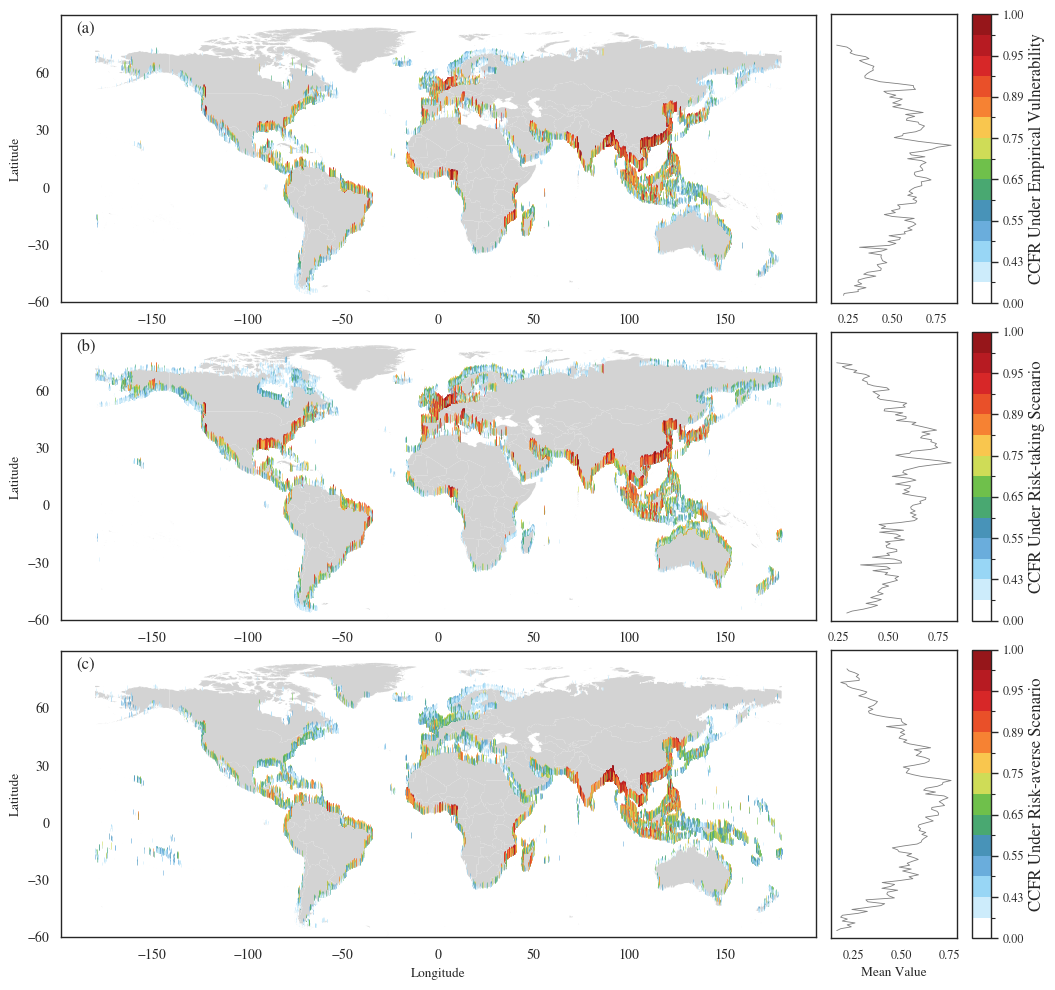

In [14]:
# ---- 自定义 colormap ----
def create_colormap():
    colors = np.genfromtxt('/public/home/jiaqizhang/JiaqiZhang/data-doctor3/WhiteBlueGreenYellowRed.rgb', skip_header=2) / 255
    return mpl.colors.ListedColormap(colors)

# ---- 基础设置 ----
sns.set(style='white', context='paper')
plt.rcParams['font.family'] = 'Nimbus Roman'

breaks = [0, 0.27144176, 0.43267487,
          0.49324241, 0.55178484, 0.6, 0.65421326, 0.70472987, 0.74888724,
          0.81432528, 0.887904, 0.92, 0.95, 0.98, 1]
cmap = create_colormap()
norm = BoundaryNorm(breaks, cmap.N)
latitude_range = np.arange(-60, 90, 30)
scale_factor = 5

# ---- 创建 Figure + GridSpec ----
fig = plt.figure(figsize=(12, 12))
gs = gridspec.GridSpec(3, 3, width_ratios=[6, 1, 0.15], height_ratios=[1, 1, 1], wspace=0.05, hspace=0.1)

# ---------------------------------------------------
# 新子图 (a): CCFR (Divergence) from df
# ---------------------------------------------------
rp1 = 'CCFR'
df[rp1] = df[rp1].replace(0, np.nan)
df['lon'] = df.geometry.centroid.x
df['lat'] = df.geometry.centroid.y

ax_map1 = fig.add_subplot(gs[0, 0])
ax_line1 = fig.add_subplot(gs[0, 1])
ax_cbar1 = fig.add_subplot(gs[0, 2])

continent.to_crs(epsg=4326).plot(ax=ax_map1, color='lightgrey', edgecolor='none')
gridnet_bars1 = df[['lon', 'lat', rp1]].dropna()
for _, row in gridnet_bars1.iterrows():
    lon, lat, height = row['lon'], row['lat'], row[rp1] * scale_factor
    ax_map1.vlines(x=lon, ymin=lat, ymax=lat + height, color=cmap(norm(row[rp1])), linewidth=0.5, alpha=0.8)

ax_map1.set_ylabel("Latitude")
ax_map1.set_ylim([-60, 90])
ax_map1.set_yticks(latitude_range)
ax_map1.tick_params(axis='both', labelsize=10)
ax_map1.text(0.02, 0.98, '(a)', transform=ax_map1.transAxes, fontsize=12, va='top', ha='left')

grouped1 = df[['lat', rp1]].dropna()
grouped1['lat_group'] = (grouped1['lat'] // 1) * 1
lat_mean1 = grouped1.groupby('lat_group')[rp1].mean()
ax_line1.plot(lat_mean1.values, lat_mean1.index, color='tab:grey', linewidth=0.6)
ax_line1.set_ylim([-60, 90])
ax_line1.set_yticks([])
ax_line1.tick_params(left=False)

sm1 = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm1.set_array([])
cbar1 = fig.colorbar(sm1, cax=ax_cbar1)
cbar1.set_label("CCFR Under Empirical Vulnerability", fontsize=12)
cbar1.formatter = ticker.FuncFormatter(lambda x, pos: f"{x:.2f}")
cbar1.update_ticks()

# ---------------------------------------------------
# 新子图 (b): CCFRtake from gridnet
# ---------------------------------------------------
rp2 = 'CCFRtake'
gridnet[rp2] = gridnet[rp2].replace(0, np.nan)
gridnet['lon'] = gridnet.geometry.centroid.x
gridnet['lat'] = gridnet.geometry.centroid.y

ax_map2 = fig.add_subplot(gs[1, 0])
ax_line2 = fig.add_subplot(gs[1, 1])
ax_cbar2 = fig.add_subplot(gs[1, 2])

continent.to_crs(epsg=4326).plot(ax=ax_map2, color='lightgrey', edgecolor='none')
gridnet_bars2 = gridnet[['lon', 'lat', rp2]].dropna()
for _, row in gridnet_bars2.iterrows():
    lon, lat, height = row['lon'], row['lat'], row[rp2] * scale_factor
    ax_map2.vlines(x=lon, ymin=lat, ymax=lat + height, color=cmap(norm(row[rp2])), linewidth=0.5, alpha=0.8)

ax_map2.set_ylabel("Latitude")
ax_map2.set_ylim([-60, 90])
ax_map2.set_yticks(latitude_range)
ax_map2.tick_params(axis='both', labelsize=10)
ax_map2.text(0.02, 0.98, '(b)', transform=ax_map2.transAxes, fontsize=12, va='top', ha='left')

grouped2 = gridnet[['lat', rp2]].dropna()
grouped2['lat_group'] = (grouped2['lat'] // 1) * 1
lat_mean2 = grouped2.groupby('lat_group')[rp2].mean()
ax_line2.plot(lat_mean2.values, lat_mean2.index, color='tab:grey', linewidth=0.6)
ax_line2.set_ylim([-60, 90])
ax_line2.set_yticks([])
ax_line2.tick_params(left=False)

sm2 = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm2.set_array([])
cbar2 = fig.colorbar(sm2, cax=ax_cbar2)
cbar2.set_label("CCFR Under Risk-taking Scenario", fontsize=12)
cbar2.formatter = ticker.FuncFormatter(lambda x, pos: f"{x:.2f}")
cbar2.update_ticks()

# ---------------------------------------------------
# 新子图 (c): CCFRaverse from gridnet
# ---------------------------------------------------
rp3 = 'CCFRaverse'
gridnet[rp3] = gridnet[rp3].replace(0, np.nan)

ax_map3 = fig.add_subplot(gs[2, 0])
ax_line3 = fig.add_subplot(gs[2, 1])
ax_cbar3 = fig.add_subplot(gs[2, 2])

continent.to_crs(epsg=4326).plot(ax=ax_map3, color='lightgrey', edgecolor='none')
gridnet_bars3 = gridnet[['lon', 'lat', rp3]].dropna()
for _, row in gridnet_bars3.iterrows():
    lon, lat, height = row['lon'], row['lat'], row[rp3] * scale_factor
    ax_map3.vlines(x=lon, ymin=lat, ymax=lat + height, color=cmap(norm(row[rp3])), linewidth=0.5, alpha=0.8)

ax_map3.set_xlabel("Longitude")
ax_map3.set_ylabel("Latitude")
ax_map3.set_ylim([-60, 90])
ax_map3.set_yticks(latitude_range)
ax_map3.tick_params(axis='both', labelsize=10)
ax_map3.text(0.02, 0.98, '(c)', transform=ax_map3.transAxes, fontsize=12, va='top', ha='left')

grouped3 = gridnet[['lat', rp3]].dropna()
grouped3['lat_group'] = (grouped3['lat'] // 1) * 1
lat_mean3 = grouped3.groupby('lat_group')[rp3].mean()
ax_line3.plot(lat_mean3.values, lat_mean3.index, color='tab:grey', linewidth=0.6)
ax_line3.set_ylim([-60, 90])
ax_line3.set_yticks([])
ax_line3.set_xlabel("Mean Value")
ax_line3.set_ylabel('')
ax_line3.tick_params(left=False)

sm3 = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm3.set_array([])
cbar3 = fig.colorbar(sm3, cax=ax_cbar3)
cbar3.set_label("CCFR Under Risk-averse Scenario", fontsize=12)
cbar3.formatter = ticker.FuncFormatter(lambda x, pos: f"{x:.2f}")
cbar3.update_ticks()

# ---- 保存 & 展示 ----
plt.savefig('CCFR_compare.pdf', format='pdf', bbox_inches='tight')
plt.savefig('CCFR_compare.png', dpi=300, bbox_inches='tight')
plt.show()